In [105]:
import os
import wfdb
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from mlp_mixerECG import FeedForward, ECGMixerBlock, MLPMixerForECG
from MlpMixerECG import MlpBlock, MixerBlock, MlpMixer

In [106]:
class ECGDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir: 데이터셋의 루트 디렉토리 (예: 'D:/mimiciv_data/mimic-iv-ecg/1.0/preprocessed')
        transform: 데이터에 적용할 변환
        """
        self.root_dir = root_dir
        self.transform = transform
        self.records = self._load_records()

    def _load_records(self):
        records = []
        # MI_F_ecg와 NOT_MI_F_ecg를 포함한 레이블 목록으로 업데이트
        for label in ['MI_M_ecg', 'NOT_MI_M_ecg', 'MI_F_ecg', 'NOT_MI_F_ecg']:
            label_dir = os.path.join(self.root_dir, label)
            for patient in os.listdir(label_dir):
                patient_dir = os.path.join(label_dir, patient)
                for session in os.listdir(patient_dir):
                    session_dir = os.path.join(patient_dir, session)
                    for file in os.listdir(session_dir):
                        if file.endswith('.hea'):
                            record_path = os.path.join(session_dir, file[:-4])  # '.hea' 확장자 제거
                            # MI_M_ecg 및 MI_F_ecg는 1로, NOT_MI_M_ecg 및 NOT_MI_F_ecg는 0으로 레이블 설정
                            records.append((record_path, 1 if 'MI_' in label else 0))
        return records

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        rec_path, label = self.records[idx]
        record = wfdb.rdrecord(rec_path)
        data = record.p_signal  # ECG 데이터 로드 및 변환

        if self.transform:
            data = self.transform(data)

        return data, label


In [107]:
# Z-점수 정규화를 위한 Custom Transform 클래스 정의
class Standardize:
    def __call__(self, sample):
        return (sample - sample.mean()) / sample.std()

# 정규화 Transform을 정의합니다.
transform = transforms.Compose([
    Standardize()
])

In [108]:
# 데이터셋 및 DataLoader 초기화
# dataset = ECGDataset('D:/mimiciv_data/mimic-iv-ecg/1.0/preprocessed')
dataset = ECGDataset(root_dir='D:/mimiciv_data/mimic-iv-ecg/1.0/preprocessed')


<Figure size 2400x1800 with 0 Axes>

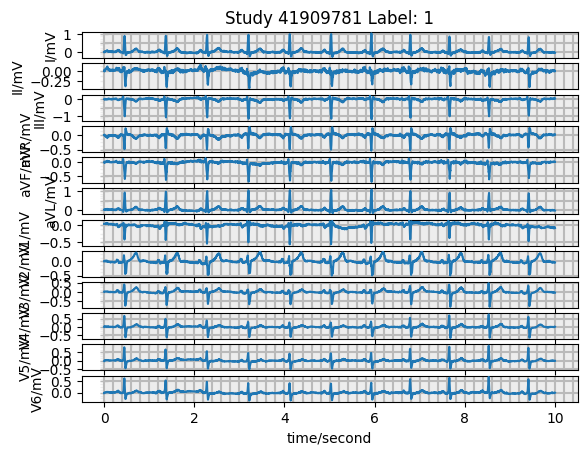

<Figure size 2400x1800 with 0 Axes>

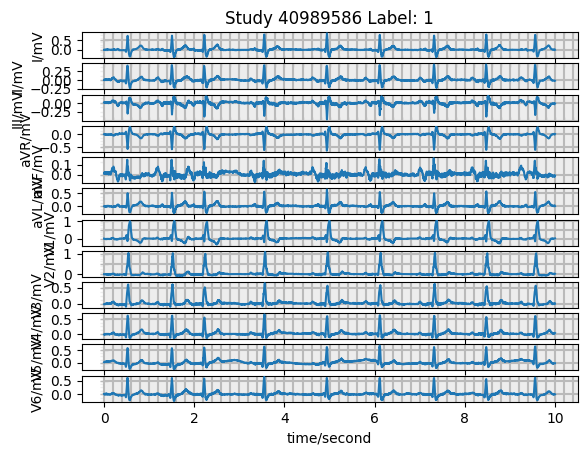

In [109]:
# 처음 2개 데이터 항목 시각화
for i in range(2):
    rec_path, label = dataset.records[i]  # 데이터셋에서 경로와 레이블을 가져옴
    record = wfdb.rdrecord(rec_path)  # rdrecord를 사용하여 데이터 로드

    # plot_wfdb를 사용하여 시각화
    plt.figure(figsize=(24, 18))
    wfdb.plot_wfdb(record=record, title=f'Study {record.record_name} Label: {label}', ecg_grids='all')
    plt.show()

In [110]:
print(dataset.records[i])

('D:/mimiciv_data/mimic-iv-ecg/1.0/preprocessed\\MI_M_ecg\\p1005\\p10052047\\40989586', 1)


In [111]:
# 첫 번째 데이터 항목 로드
first_data, first_label = dataset[0]

# ECG 데이터와 레이블 출력
print("First ECG Data Shape:", first_data.shape)
print("First ECG Data Label:", first_label)


First ECG Data Shape: (5000, 12)
First ECG Data Label: 1


In [112]:
print(len(dataset))

1742


In [113]:
# 데이터셋 크기
total_size = len(dataset)

# 훈련 세트와 테스트 세트의 크기 계산
train_size = int(0.9 * total_size)
test_size = total_size - train_size

# 데이터셋을 훈련 세트와 테스트 세트로 무작위 분할
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoader 인스턴스 생성
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=False)

# 분할된 데이터셋 크기 확인
print(f'Total dataset size: {total_size}')
print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')


Total dataset size: 1742
Train dataset size: 1567
Test dataset size: 175


In [114]:
# 모델 인스턴스 생성, 이제 ECG 데이터의 12개 리드에 맞게 설정됨
# model = MLPMixerForECG(num_classes=2, seq_len=5000, num_channels=12, depth=6, token_dim=64, channel_dim=256)
model = MlpMixer(num_channels=12, hidden_dim=8, mlp_token_dim=16, mlp_channel_dim=16, seq_len=5000, num_blocks=2, num_classes=2)

# GPU가 사용 가능한지 확인하고, 사용 가능하다면 GPU를 사용합니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # 모델을 GPU로 이동시킵니다.

print(device)



cuda


In [115]:
# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
# 학습률 스케줄러 설정
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.95, patience=10)


In [116]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device).float()
        labels = labels.to(device).long()
        inputs = inputs.permute(0, 2, 1)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 첫 번째 배치의 첫 번째 손실과 출력값 출력
        if i == 0:
            print(f'First batch, first prediction in this epoch: {predicted[0]}')
            print(f'First batch, first loss in this epoch: {loss.item()}')

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    print(f'Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}%')
    return epoch_acc

In [117]:
def validate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device).float()  
            labels = labels.to(device).long()
            inputs = inputs.permute(0, 2, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 첫 번째 배치의 첫 번째 손실과 출력값 출력
            if i == 0:
                print(f'First batch, prediction in this epoch: {predicted[0]}')
                print(f'First batch, loss in this epoch: {loss.item()}')

    epoch_loss = running_loss / len(test_loader)
    epoch_acc = 100 * correct / total

    print(f'Validation Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}%')
    return epoch_acc


In [118]:
num_epochs = 20

Epoch 1/20


First batch, first prediction in this epoch: 1
First batch, first loss in this epoch: 0.5927743315696716
Training Loss: nan, Accuracy: 6.0625%
First batch, prediction in this epoch: 0
First batch, loss in this epoch: nan
Validation Loss: nan, Accuracy: 0.0000%
Epoch 2/20
First batch, first prediction in this epoch: 0
First batch, first loss in this epoch: nan
Training Loss: nan, Accuracy: 0.0000%
First batch, prediction in this epoch: 0
First batch, loss in this epoch: nan
Validation Loss: nan, Accuracy: 0.0000%
Epoch 3/20
First batch, first prediction in this epoch: 0
First batch, first loss in this epoch: nan
Training Loss: nan, Accuracy: 0.0000%
First batch, prediction in this epoch: 0
First batch, loss in this epoch: nan
Validation Loss: nan, Accuracy: 0.0000%
Epoch 4/20
First batch, first prediction in this epoch: 0
First batch, first loss in this epoch: nan
Training Loss: nan, Accuracy: 0.0000%
First batch, prediction in this epoch: 0
First batch, loss in this epoch: nan
Validati

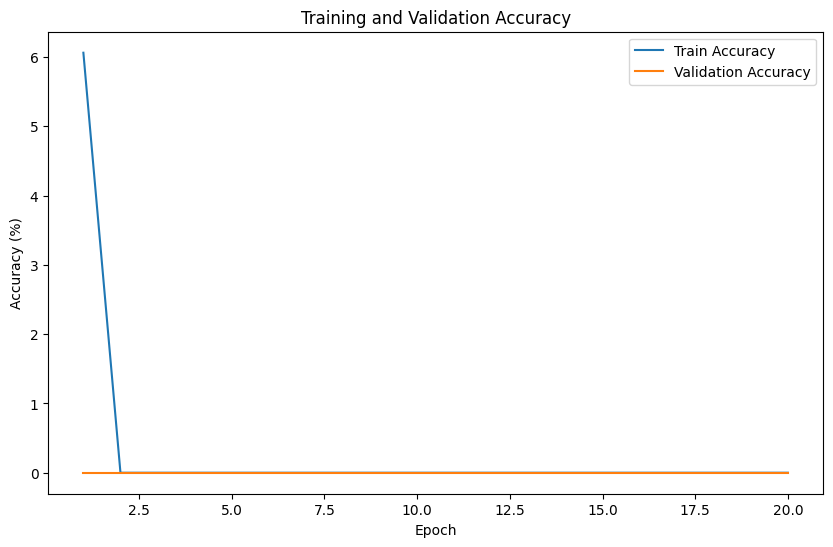

In [119]:
# 정확도 기록을 저장할 리스트 초기화
train_accuracies = []
validation_accuracies = []
    
# 훈련 및 검증 루프
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    train_acc = train(model, train_loader, criterion, optimizer, device)
    val_acc = validate(model, test_loader, criterion, device)
    
    # 정확도 기록
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

# 정확도 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
